In [ ]:
!pip install simpy

In [ ]:
import simpy
import matplotlib.pyplot as plt
import numpy as np
import random

# Начальные параметры
max_time = 100.0  # Общее время моделирования
mu_ =  [6, 4, 2]  # Среднее время обслуживания для каждого из трех серверов
lambda_ = [250, 500, 750]  # Средние интенсивности поступления заявок для трех потоков
capacities = [10000, 15000, 20000]  # Емкости серверов edge, fog, cloud
color_list = ['#5B9BD5', '#ED7D31', '#70AD47']  # Цвета для графиков

def process_request(env, server):
    with server['resource'].request() as req:
        yield req
        server['number_of_task'][env.now] = server['resource'].count
        server['moving_average'][env.now] = sum(server['number_of_task'].values()) / len(server['number_of_task'].values())
        service_time = random.expovariate(server['mu'])
        yield env.timeout(service_time)
        server['number_of_task'][env.now] = server['resource'].count
        server['moving_average'][env.now] = sum(server['number_of_task'].values()) / len(server['number_of_task'].values())


def generate_requests(env, servers, stream_lambda):
    while True:
        inter_arrival_time = random.expovariate(stream_lambda)
        yield env.timeout(inter_arrival_time)
        num_s = random.choice([i for i in range(len(servers))])
        c = process_request(env, servers[num_s])
        env.process(c)


def run_simulation(max_time, mu_, lambda_, capacities):
    env = simpy.Environment()
    servers = []

    for i, capacity in enumerate(capacities):
        resource = simpy.Resource(env, capacity=capacity)
        number_of_task = {}
        moving_average = {}
        servers.append({
            'resource': resource,
            'number_of_task': number_of_task, # Словарь с количеством заявок по времени.
            'moving_average': moving_average, # Скользящее среднее количества заявок в системе
            'mu': mu_[i]
        })

    for stream_lambda in lambda_:
      env.process(generate_requests(env, servers, stream_lambda))
    env.run(until=max_time)
    print('All done!')

    return env, servers

In [ ]:
env, servers = run_simulation(max_time, mu_, lambda_, capacities)

All done!


In [ ]:
def plot_results(server, max_time, lambda_, color):
    plt.plot(server['number_of_task'].keys(), server['number_of_task'].values(), label='Случайный процесс', color=color, alpha=0.5)
    plt.plot(server['moving_average'].keys(), server['moving_average'].values(), label='Скользящее среднее', color=color)
    plt.plot(server['number_of_task'].keys(), [np.sum(lambda_) / 3 / server['mu'] for _ in server['number_of_task'].keys()], label='Теоретическое среднее', color=color, linestyle = '--')
    plt.xlim(0, max_time)
    plt.ylim(0, 350)
    plt.grid(linestyle='--', alpha=0.5)
    plt.xlabel('Время')
    plt.ylabel('Количество заявок')
    plt.legend(loc=1)
    plt.show()

    plt.hist(list(server['number_of_task'].values()), density=True, bins=np.linspace(0, 350, 50), color=color, alpha=0.5)
    plt.axvline((np.mean(list(server['number_of_task'].values()))), color=color, linestyle='-', linewidth=1, label='Эмпирическое среднее')
    plt.axvline((np.sum(lambda_) / 3 / server['mu']), color=color, linestyle='--', linewidth=1, label='Теоретическое среднее')
    plt.xlim(0, 350)
    plt.ylim(0, 0.05)
    plt.xlabel('Количество заявок')
    plt.ylabel('Вероятность')
    plt.grid(linestyle='--', alpha=0.5)
    plt.legend(loc=1)
    plt.show()

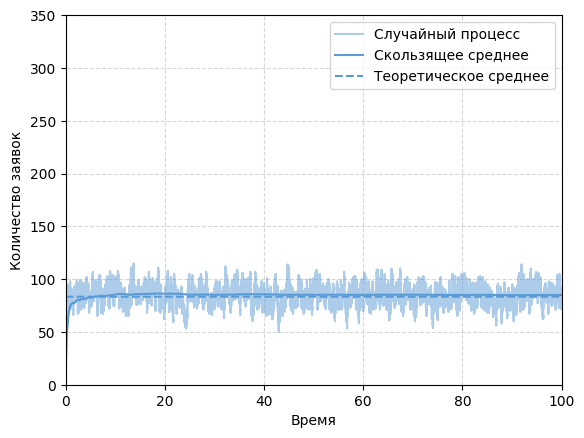

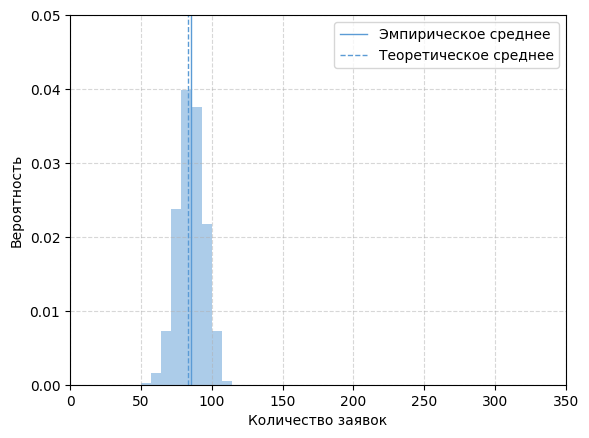

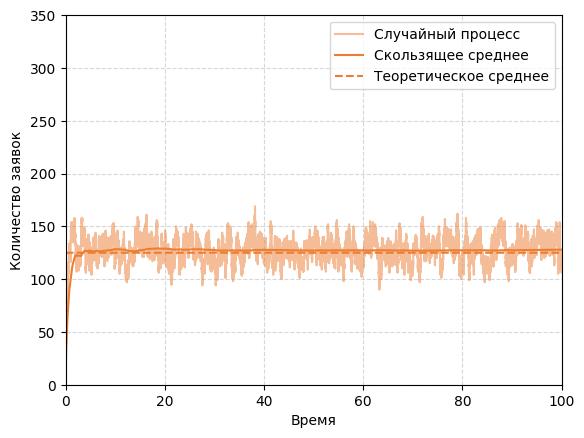

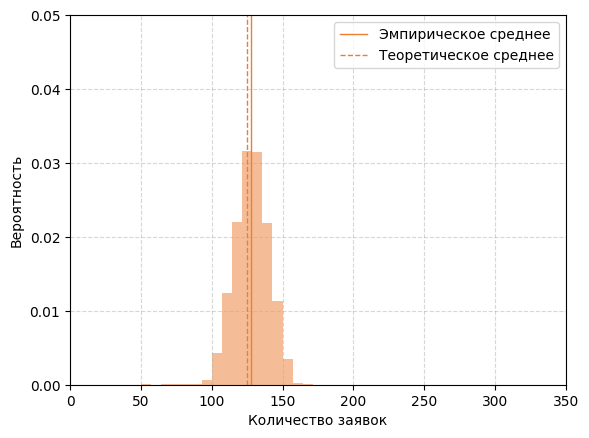

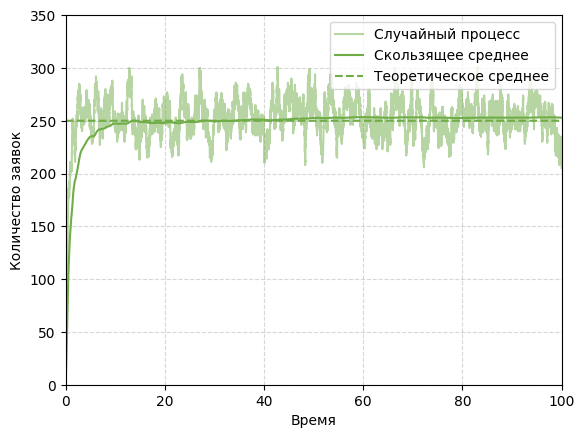

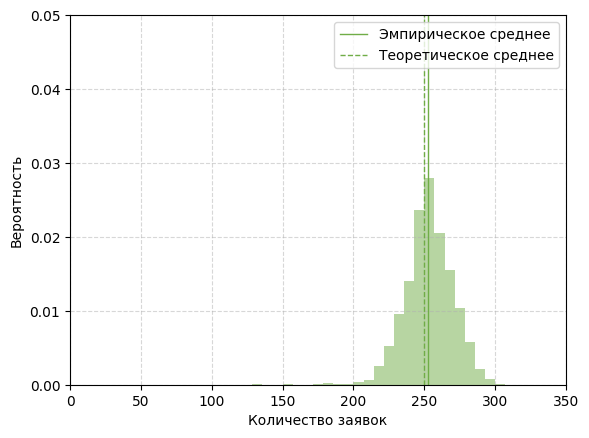

In [ ]:
for i, server in enumerate(servers):
    plot_results(server, max_time, lambda_, color_list[i])

In [ ]:
import simpy
import matplotlib.pyplot as plt
import numpy as np
import random

max_time = 100.0  # Общее время моделирования
mu_ =  [6, 4, 2]  # Среднее время обслуживания для каждого из трех серверов
lambda_ = [250, 500, 750]  # Средние интенсивности поступления заявок для трех потоков
capacities = [10000, 15000, 20000]  # Емкости серверов edge, fog, cloud
n_values = [0.01, 0.1, 1]  # Модификаторы для Лямбд
color_list = ['#5B9BD5', '#ED7D31', '#70AD47']  # Цвета для графиков


def process_request(env, server):
    with server['resource'].request() as req:
        yield req
        server['number_of_task'][env.now] = server['resource'].count
        server['moving_average'][env.now] = sum(server['number_of_task'].values()) / len(server['number_of_task'].values())
        service_time = random.expovariate(server['mu'])
        yield env.timeout(service_time)
        server['number_of_task'][env.now] = server['resource'].count
        server['moving_average'][env.now] = sum(server['number_of_task'].values()) / len(server['number_of_task'].values())


def generate_requests(env, servers, stream_lambda):
    while True:
        inter_arrival_time = random.expovariate(stream_lambda)
        yield env.timeout(inter_arrival_time)
        num_s = random.choice([i for i in range(len(servers))])
        c = process_request(env, servers[num_s])
        env.process(c)


def run_simulation(max_time, mu_, lambda_, capacities):
    env = simpy.Environment()
    servers = []
    total_requests = {}

    for i, capacity in enumerate(capacities):
        resource = simpy.Resource(env, capacity=capacity)
        number_of_task = {}
        moving_average = {}
        servers.append({
            'resource': resource,
            'number_of_task': number_of_task, # Словарь с количеством заявок по времени.
            'moving_average': moving_average, # Скользящее среднее количества заявок в системе
            'mu': mu_[i]
        })

    for stream_lambda in lambda_:
      env.process(generate_requests(env, servers, stream_lambda))
    env.run(until=max_time)
    for server in servers:
      for key in server['number_of_task'].keys():
        if(key in total_requests.keys()):
          total_requests[key] += server['number_of_task'][key]
        else:
          total_requests[key] = server['number_of_task'][key]
    print('All done!')

    return env, servers, total_requests


def generate_requests_per_n_servers(max_time, mu_, lambda_, capacities, n_values): # среднее для каждого сервера
    plt.figure(figsize=(10, 6))
    avg_requests_data = {i: [] for i in range(len(mu_))}

    for n in n_values:
      temp_lambda = list(lambda_)
      for l in range(len(temp_lambda)):
        temp_lambda[l] *= n
      env, servers, requests_system = run_simulation(max_time, mu_, temp_lambda, capacities)

      for server_index, server in enumerate(servers):
          avg_requests = np.mean(list(server['number_of_task'].values()))
          avg_requests_data[server_index].append(avg_requests)

    return avg_requests_data

In [ ]:
avg_requests_data = generate_requests_per_n_servers(max_time, mu_, lambda_, capacities, n_values)

All done!
All done!
All done!


<Figure size 1000x600 with 0 Axes>

In [ ]:
label_list = ['Узел 1 - Край', 'Узел 2 - Туман', 'Узел 3 - Облако']
marker_list = ['o', '^', 's']

In [ ]:
def plot_gen_n_servers(avg_requests_data):
  for i, avg_requests_values in avg_requests_data.items():
      plt.plot(n_values, avg_requests_values, label=label_list[i], marker=marker_list[i], linestyle='-')
  plt.grid(linestyle='--', alpha=0.5)
  plt.xlabel('Коэффициент роста интенсивности поступления заявок, $n$')
  plt.ylabel('Среднее количество заявок на узле')
  plt.legend(loc=2)
  plt.xscale('log')
  plt.ylim(0, 250)
  plt.xlim(0.1, 1)
  plt.show()

In [ ]:
print(avg_requests_data)

{0: [9.490986529318542, 43.073637644071496, 84.34584925183063], 1: [13.116945350734095, 64.37631464922993, 126.52344084735799], 2: [25.646231155778896, 126.84914171656686, 251.42195430839342]}


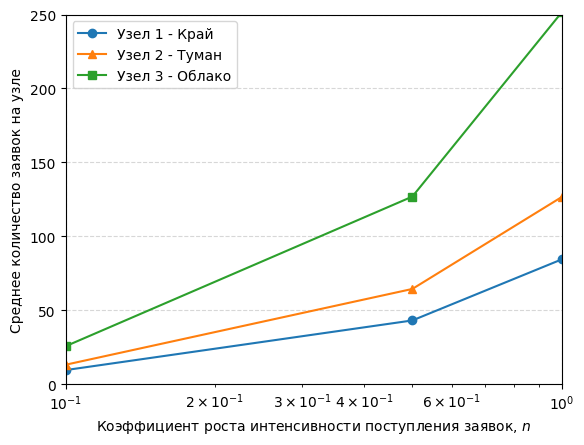

In [ ]:
plot_gen_n_servers(avg_requests_data)